# Collars
Price collars using different models. If vanillas match, we expect collars to match as well. Consider this notebook as a prequel to the note book on [Forward Collars](03b_FwdCollars.ipynb).

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow as pa
from finmc.models.heston import HestonMC
from matplotlib import pyplot as plt
from qablet.base.mc import MCPricer
from qablet_contracts.timetable import TS_EVENT_SCHEMA

from data.spx_2005_09_15 import basic_info, dataset
from src.model.localvol import LVMC
from src.model.rbergomi import rBergomiMC

In [2]:
# We will compare everything with the SVI implied volatilities on 2005-09-15
prc_dt = basic_info["prc_dt"]
ticker = basic_info["ticker"]
spot = basic_info["spot"]

# We will use a collar width of 1%
width = 0.01 * spot

### Collars
Collars are not in the qablet_contracts package. We will write a method to create collars here, using the [qablet specifications](https://qablet.github.io/qablet-contracts/specifications/timetable/). A collar pays at maturity, based on a cap and floor from a collar width.

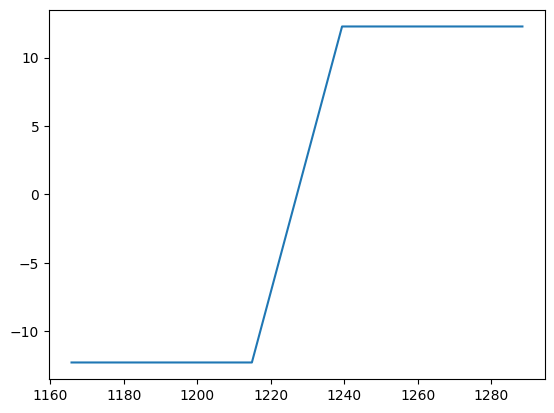

In [3]:
# Define collar phrase, which is spot - K, capped and floored.
strike = spot


def collar_pay_fn(inputs):
    [s] = inputs

    ret = np.maximum(-width, s - strike)
    ret = np.minimum(width, ret)

    return [ret]


# let's plot the collar payoffs
s_vec = np.linspace(strike - 0.05 * spot, strike + 0.05 * spot, 11)
pay_vec = collar_pay_fn([s_vec])
plt.plot(s_vec, pay_vec[0])

In [4]:
# Create a Collar timetable using the above collar fn
def collar_timetable(ticker, maturity):
    events = [
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",
        },
    ]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker],
                "fn": collar_pay_fn,
            },
        },
    }


# Try an example:
timetable = collar_timetable(ticker, datetime(2013, 12, 31))
print(timetable["events"].to_pandas())

                       time op  quantity    unit track
0 2013-12-31 00:00:00+00:00  +       1.0  COLLAR      


Create a series of collars starting at different expiration dates.

In [5]:
exp_dates = []
timetables = []
for i in range(6):
    exp_dt = prc_dt + pd.DateOffset(months=2 * i + 2)
    exp_dates.append(exp_dt)
    timetables.append(
        collar_timetable(
            ticker,
            maturity=exp_dt,
        )
    )
df = pd.DataFrame({"exp date": exp_dates})
df

,exp date
0,2005-11-14
1,2006-01-14
2,2006-03-14
3,2006-05-14
4,2006-07-14
5,2006-09-14


### Compare Models
Compare different models, starting with Local Volatility Model.

In [6]:
model = MCPricer(LVMC)

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)

df["LocalVol"] = prices
df

,exp date,LocalVol
0,2005-11-14,2.709827
1,2006-01-14,2.873626
2,2006-03-14,3.025723
3,2006-05-14,3.112570
4,2006-07-14,3.167875
5,2006-09-14,3.186637


Heston Model

In [7]:
model = MCPricer(HestonMC)

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["Heston"] = prices
df

,exp date,LocalVol,Heston
0,2005-11-14,2.709827,2.299740
1,2006-01-14,2.873626,2.839489
2,2006-03-14,3.025723,3.086085
3,2006-05-14,3.112570,3.206615
4,2006-07-14,3.167875,3.247730
5,2006-09-14,3.186637,3.278776


Bergomi Model

In [8]:
model = MCPricer(rBergomiMC)

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,exp date,LocalVol,Heston,rBergomi
0,2005-11-14,2.709827,2.299740,2.835026
1,2006-01-14,2.873626,2.839489,3.038516
2,2006-03-14,3.025723,3.086085,3.076330
3,2006-05-14,3.112570,3.206615,3.127089
4,2006-07-14,3.167875,3.247730,3.205786
5,2006-09-14,3.186637,3.278776,3.235879


## Plot

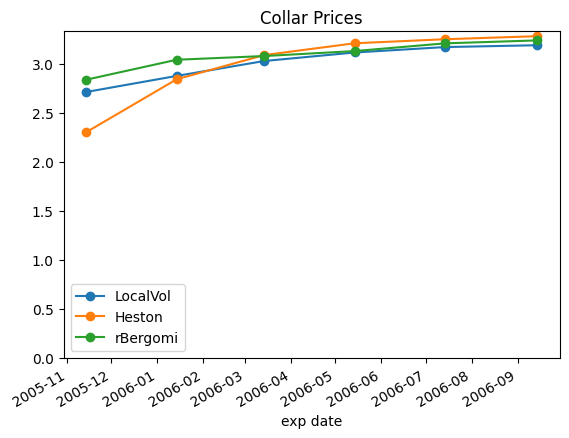

In [9]:
df.columns
df.plot(
    x="exp date",
    y=["LocalVol", "Heston", "rBergomi"],
    marker="o",
    title="Collar Prices",
)
plt.ylim(bottom=0)  # This includes 0 at the y-axis
plt.show()